In [43]:
from xml.etree import ElementTree
from os import listdir
import numpy as np
from mrcnn.utils import Dataset
from matplotlib import pyplot


class TestPiecesCarrierDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class('dataset', 1, 'test_piece')
        self.add_class('dataset', 2, 'carrier')
        
        images_dir = dataset_dir + '/pos/'
        annotations_dir = dataset_dir + '/annotations/'
        
        for filename in listdir(images_dir):
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            
            
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        print(path)
        boxes, w, h = self.parse_bounding_boxes(path)
        # matterport (sikit.io) load_image returns hw not wh
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        print("xmin", boxes[0][0], "ymin", boxes[0][1], "xmax", boxes[0][2],"ymax", boxes[0][3])
        class_ids = []
        print(len(boxes), " width ", w, " height ", h)
        for i in range(len(boxes)):
            box = boxes[i]
            # load masks like this hw and rs, re, cs, ce = 1, 3, 0, 2 
            # and use imshow with rotated, if image has not same rotation as annotation program
            # ==> this sucks, maybe create new Dataset that you dont have to rotate "manually", or find smart solution
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            print("rows", row_s, "rowe", row_e, "cols", col_s, "cole",  col_e)
            masks[row_s:row_e, col_s:col_e, i] = 1
            # append class_id per bounding box
            if box[4] == 1:
                class_ids.append(self.class_names.index('test_piece'))    
            else:
                class_ids.append(self.class_names.index('carrier'))
        return masks, np.asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']
        
    def parse_bounding_boxes(self, src):
        tree = ElementTree.parse(src)
        root = tree.getroot()
        bdboxes = []
        
        for b in root.findall('.//object'):
            name = 1 if str(b.find('name').text) == 'test_piece' else 2
            xmin = int(b.find('bndbox/xmin').text)
            ymin = int(b.find('bndbox/ymin').text)
            xmax = int(b.find('bndbox/xmax').text)
            ymax = int(b.find('bndbox/ymax').text)
            xywh_n = [xmin, ymin, xmax, ymax, name]
            bdboxes.append(xywh_n)
        width = int(root.find('.//size/width').text) 
        height = int(root.find('.//size/height').text)
        return bdboxes, width, height


image:  (3000, 4000, 3)
img/annotations/Pos_00.xml
xmin 1 ymin 133 xmax 1433 ymax 2098
5  width  4000  height  3000
rows 133 rowe 2098 cols 1 cole 1433
rows 144 rowe 1228 cols 2383 cole 2888
rows 28 rowe 1205 cols 2700 cole 3255
rows 1 rowe 1094 cols 3024 cole 3538
rows 1 rowe 1185 cols 3258 cole 3981
masks:  (3000, 4000, 5)
0 {'id': 'Pos_00', 'source': 'dataset', 'path': 'img/pos/Pos_00.jpg', 'annotation': 'img/annotations/Pos_00.xml'}
1 {'id': 'Pos_04', 'source': 'dataset', 'path': 'img/pos/Pos_04.jpg', 'annotation': 'img/annotations/Pos_04.xml'}
2 {'id': 'Pos_07', 'source': 'dataset', 'path': 'img/pos/Pos_07.jpg', 'annotation': 'img/annotations/Pos_07.xml'}
3 {'id': 'Pos_08', 'source': 'dataset', 'path': 'img/pos/Pos_08.jpg', 'annotation': 'img/annotations/Pos_08.xml'}
4 {'id': 'Pos_09', 'source': 'dataset', 'path': 'img/pos/Pos_09.jpg', 'annotation': 'img/annotations/Pos_09.xml'}
5 {'id': 'Pos_10', 'source': 'dataset', 'path': 'img/pos/Pos_10.jpg', 'annotation': 'img/annotations/Po

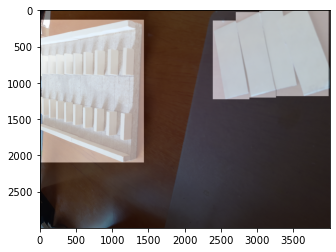

In [46]:
# test purposes only, check if image and masks are loaded correctly 
train_set = TestPiecesCarrierDataset()
train_set.load_dataset('img')
train_set.prepare()

image_id = 0
image = train_set.load_image(image_id)
print("image: " ,image.shape)

masks, class_ids = train_set.load_mask(image_id)
print("masks: ", masks.shape)
mask = masks[:, :, 0]
i = 1
while i < masks.shape[2]:
    mask = mask | masks[:, :, i]
    i += 1

pyplot.imshow(image)
pyplot.imshow(mask, cmap='gray', alpha=0.5)
pyplot.show()

# check image info objects
for id in train_set.image_ids: 
    info = train_set.image_info[id]
    print(id, info)

img/annotations/Pos_00.xml
xmin 1 ymin 133 xmax 1433 ymax 2098
5  width  4000  height  3000
rows 133 rowe 2098 cols 1 cole 1433
rows 144 rowe 1228 cols 2383 cole 2888
rows 28 rowe 1205 cols 2700 cole 3255
rows 1 rowe 1094 cols 3024 cole 3538
rows 1 rowe 1185 cols 3258 cole 3981


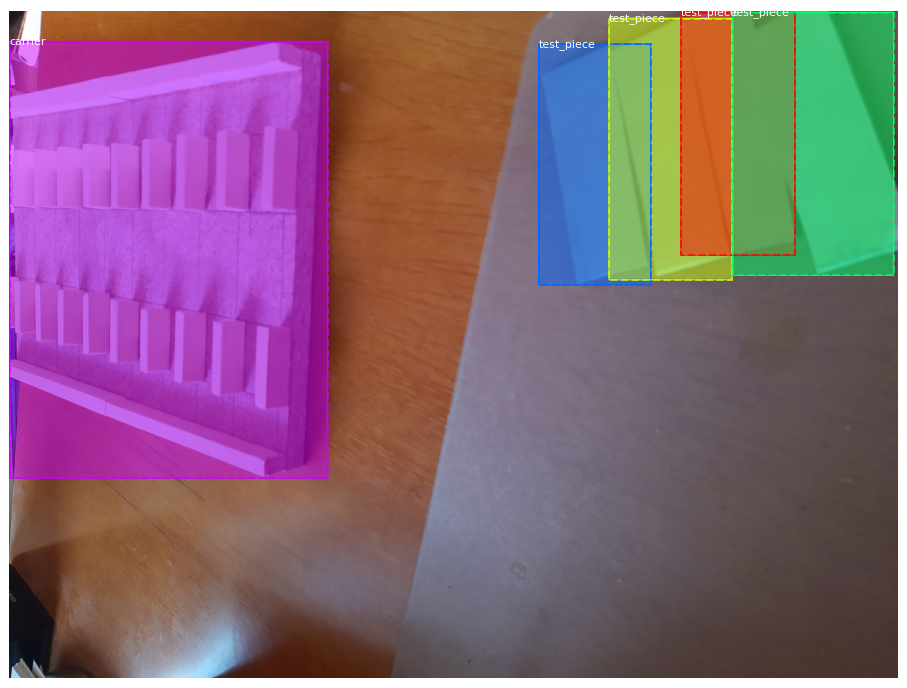

In [50]:

#display bboxes, masks, class labels, to confirm dataset again
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

image_id = 0
image = train_set.load_image(image_id)
masks, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(masks)

display_instances(image, bbox, masks, class_ids, train_set.class_names)

